### LSTM (Long-short time memory) model for SOC prediction with using Panasonic 18650PF Li-ion Battery 

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
PROCESSED_DATA_DIR = '../../datasets/Panasonic_dataset/Panasonic_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Current Average', 'Voltage Average', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 2048
SEQUENCE_LENGTH = 20  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [5]:
# Custom dataset class for LSTM
class BatteryDatasetLSTM(Dataset):
    def __init__(self, data_tensor, labels_tensor, sequence_length=50, filenames=None, times=None):
        self.sequence_length = sequence_length
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        sequence = self.features[idx:idx_end]
        label = self.labels[idx_end - 1]
        filename = self.filenames[idx_end - 1]
        time = self.times[idx_end - 1]  

        sequence = sequence.clone().detach()
        label = label.clone().detach()

        return sequence, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [6]:
# SoCLSTM Model
class SoCLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SoCLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001, flag=False):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')
        
        if flag:
            model_path = "soc_lstm_model.pth"
            torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)
        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [8]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [9]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 12:56:50,50.000996,3.95155,-1.21840,0.539533,-0.01341,3.990077,-0.962472,0.000029,-0.013320,0.994895,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-4.814569
1,2017-05-30 12:56:50,50.100000,3.93868,-1.38009,0.539533,-0.01345,3.989822,-0.961564,0.000028,-0.013358,0.994881,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.435733
2,2017-05-30 12:56:50,50.198993,3.93032,-1.42908,0.550856,-0.01349,3.989647,-0.960691,0.000027,-0.013397,0.994866,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.616742
3,2017-05-30 12:56:50,50.302000,3.92646,-1.44378,0.550856,-0.01353,3.989533,-0.959801,0.000029,-0.013438,0.994850,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.668944
4,2017-05-30 12:56:50,50.407995,3.92324,-1.45032,0.550856,-0.01357,3.989462,-0.958890,0.000029,-0.013481,0.994833,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-5.689953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728549,2017-06-25 11:15:24,2660.842005,3.50263,0.00000,-11.985971,-1.74012,3.501051,0.000000,0.000029,-1.740425,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.000000
3728550,2017-06-25 11:15:24,2660.938001,3.50263,0.00000,-11.985971,-1.74012,3.501059,0.000000,0.000027,-1.740425,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.000000
3728551,2017-06-25 11:15:24,2661.040002,3.50263,0.00000,-11.985971,-1.74012,3.501067,0.000000,0.000028,-1.740425,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.000000
3728552,2017-06-25 11:15:24,2661.138000,3.50263,0.00000,-11.985971,-1.74012,3.501073,0.000000,0.000027,-1.740425,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.000000


In [10]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 12:56:50,50.000996,1.245229,-0.122483,-0.599801,-0.01341,1.471286,0.036451,0.000029,1.653512,0.994895,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.233277
1,2017-05-30 12:56:50,50.100000,1.199808,-0.210323,-0.599801,-0.01345,1.470324,0.037440,0.000028,1.653459,0.994881,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.332731
2,2017-05-30 12:56:50,50.198993,1.170304,-0.236938,-0.599011,-0.01349,1.469663,0.038389,0.000027,1.653404,0.994866,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.361712
3,2017-05-30 12:56:50,50.302000,1.156682,-0.244924,-0.599011,-0.01353,1.469230,0.039358,0.000029,1.653346,0.994850,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.370070
4,2017-05-30 12:56:50,50.407995,1.145318,-0.248477,-0.599011,-0.01357,1.468963,0.040349,0.000029,1.653286,0.994833,05-30-17_12.56 0degC_Cycle_1_Pan18650PF_proces...,-0.373433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728549,2017-06-25 11:15:24,2660.842005,-0.339081,0.539426,-1.473899,-1.74012,-0.375631,1.083927,0.000029,-0.767030,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.537575
3728550,2017-06-25 11:15:24,2660.938001,-0.339081,0.539426,-1.473899,-1.74012,-0.375602,1.083927,0.000027,-0.767030,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.537575
3728551,2017-06-25 11:15:24,2661.040002,-0.339081,0.539426,-1.473899,-1.74012,-0.375573,1.083927,0.000028,-0.767030,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.537575
3728552,2017-06-25 11:15:24,2661.138000,-0.339081,0.539426,-1.473899,-1.74012,-0.375548,1.083927,0.000027,-0.767030,0.000000,06-25-17_10.31 n20degC_US06_Pan18650PF_process...,0.537575


In [11]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [12]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [13]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [14]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetLSTM(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetLSTM(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetLSTM(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    SEQUENCE_LENGTH,
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [15]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'06-02-17_04.58 0degC_US06_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_NN_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv', '06-24-17_04.29 n20degC_Cycle_1_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_US06_Pan18650PF_processed.csv', '04-05-17_22.50 10degC_Cycle_4_Pan18650PF_processed.csv', '03-21-17_09.38 25degC_LA92_Pan18650PF_processed.csv', '06-11-17_01.39 n10degC_Cycle_3_Pan18650PF_processed.csv', '03-28-17_12.51 10degC_Cycle_1_Pan18650PF_processed.csv', '06-10-17_11.25 n10degC_Cycle_1_Pan18650PF_processed.csv', '03-28-17_18.18 10degC_Cycle_2_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv', '03-19-17_03.25 25degC_Cycle_2_Pan18650PF_processed.csv', '06-11-17_08.42 n10degC_Cycle_4_Pan18650PF_processed.csv', '03-20-17_19.27 25degC_

In [17]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([2915916, 7])
Test features shape: torch.Size([459641, 7])
Train labels shape: torch.Size([2915916])
Test labels shape: torch.Size([459641])


## Hyperparameter tuning

In [18]:
# Define Optuna objective function
EPOCHS = 10
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 128)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    # Instantiate model with suggested hyperparameters
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).type(torch.float32).to(device)

    # Define your loss function and optimizer with suggested hyperparameters
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Call your train and validate function
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Extract last validation loss
    last_val_loss = history['val_loss'][-1]
    return last_val_loss


In [32]:
# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Extract best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial}")

best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

[I 2025-08-01 16:50:59,746] A new study created in memory with name: no-name-0d53f913-5cd0-411e-8ab1-bb7458e2efe0
Epoch: 0/10: 100%|██████████| 1914/1914 [06:33<00:00,  4.87it/s]


Epoch 1/10, Train Loss: 0.09305231743506784, Validation Loss: 0.02980081808490573
Time taken for epoch: 393.38114667 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [06:31<00:00,  4.89it/s]


Epoch 2/10, Train Loss: 0.00970413368642953, Validation Loss: 0.004529376737760555
Time taken for epoch: 391.18705773 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [06:30<00:00,  4.90it/s]


Epoch 3/10, Train Loss: 0.004929081575999517, Validation Loss: 0.002604978950742442
Time taken for epoch: 390.62264442 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [06:36<00:00,  4.83it/s]


Epoch 4/10, Train Loss: 0.003222200355946029, Validation Loss: 0.00172166923830094
Time taken for epoch: 396.43539715 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [06:39<00:00,  4.79it/s]


Epoch 5/10, Train Loss: 0.002148867821001692, Validation Loss: 0.0012268908951368481
Time taken for epoch: 399.31826019 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [06:36<00:00,  4.82it/s]


Epoch 6/10, Train Loss: 0.0016572023673779102, Validation Loss: 0.0009126449305707594
Time taken for epoch: 396.77679443 seconds


Epoch: 6/10: 100%|██████████| 1914/1914 [06:37<00:00,  4.82it/s]


Epoch 7/10, Train Loss: 0.0014560818978120128, Validation Loss: 0.0007237406405200603
Time taken for epoch: 397.00838065 seconds


Epoch: 7/10: 100%|██████████| 1914/1914 [06:36<00:00,  4.82it/s]


Epoch 8/10, Train Loss: 0.001351663626632152, Validation Loss: 0.0006244209919548375
Time taken for epoch: 396.85490513 seconds


Epoch: 8/10: 100%|██████████| 1914/1914 [06:30<00:00,  4.90it/s]


Epoch 9/10, Train Loss: 0.0012790941031865753, Validation Loss: 0.0005824778850610176
Time taken for epoch: 390.99772763 seconds


Epoch: 9/10: 100%|██████████| 1914/1914 [06:27<00:00,  4.94it/s]
[I 2025-08-01 18:02:06,138] Trial 0 finished with value: 0.0005813943599751129 and parameters: {'hidden_size': 16, 'num_layers': 2, 'learning_rate': 1.732989300141742e-05}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.0012248963737508036, Validation Loss: 0.0005813943599751129
Time taken for epoch: 387.34162831 seconds


Epoch: 0/10: 100%|██████████| 1914/1914 [06:51<00:00,  4.65it/s]


Epoch 1/10, Train Loss: 0.0009214385660213653, Validation Loss: 0.0006031195313456146
Time taken for epoch: 411.32205677 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [06:54<00:00,  4.62it/s]


Epoch 2/10, Train Loss: 0.0003556332744147323, Validation Loss: 0.0008200716909486901
Time taken for epoch: 414.52045083 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [06:55<00:00,  4.60it/s]


Epoch 3/10, Train Loss: 0.00029224685567136527, Validation Loss: 0.000730627373178047
Time taken for epoch: 415.85169029 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [06:56<00:00,  4.60it/s]


Epoch 4/10, Train Loss: 0.00023126235754257593, Validation Loss: 0.0008072007349783335
Time taken for epoch: 416.38886714 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [06:48<00:00,  4.68it/s]


Epoch 5/10, Train Loss: 0.00017977539246507494, Validation Loss: 0.0009640774327339416
Time taken for epoch: 408.81216025 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [06:50<00:00,  4.66it/s]


Epoch 6/10, Train Loss: 0.00014907743374077708, Validation Loss: 0.0008691601254468321
Time taken for epoch: 410.92027926 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 1914/1914 [06:46<00:00,  4.71it/s]


Epoch 7/10, Train Loss: 0.0001431963498999857, Validation Loss: 0.0008887282543012523
Time taken for epoch: 406.45619512 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 1914/1914 [06:50<00:00,  4.66it/s]


Epoch 8/10, Train Loss: 0.00011434839125799284, Validation Loss: 0.0008817144480480293
Time taken for epoch: 410.76156664 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 1914/1914 [06:46<00:00,  4.71it/s]


Epoch 9/10, Train Loss: 0.00010052689129684719, Validation Loss: 0.0008928963771385
Time taken for epoch: 406.56657171 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 1914/1914 [06:46<00:00,  4.71it/s]
[I 2025-08-01 19:16:12,517] Trial 1 finished with value: 0.0010306674070999853 and parameters: {'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.007264401029476724}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.00011074423064381824, Validation Loss: 0.0010306674070999853
Time taken for epoch: 406.74656725 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [09:09<00:00,  3.48it/s]


Epoch 1/10, Train Loss: 0.009224921655661135, Validation Loss: 0.0005675257785063756
Time taken for epoch: 549.85444427 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [09:11<00:00,  3.47it/s]


Epoch 2/10, Train Loss: 0.0007805499394668525, Validation Loss: 0.0006477909371809279
Time taken for epoch: 551.55814886 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [09:18<00:00,  3.42it/s]


Epoch 3/10, Train Loss: 0.0005371036764821612, Validation Loss: 0.0007831751843655913
Time taken for epoch: 558.98389792 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [09:10<00:00,  3.48it/s]


Epoch 4/10, Train Loss: 0.0004712468151357356, Validation Loss: 0.0006955107025874614
Time taken for epoch: 550.52272487 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [09:32<00:00,  3.34it/s]


Epoch 5/10, Train Loss: 0.00042249942597699067, Validation Loss: 0.0007208027071588651
Time taken for epoch: 572.89744949 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [11:27<00:00,  2.79it/s]


Epoch 6/10, Train Loss: 0.0003925596888654193, Validation Loss: 0.0008927291414184409
Time taken for epoch: 687.02465177 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 1914/1914 [08:58<00:00,  3.56it/s]


Epoch 7/10, Train Loss: 0.00036979866427098876, Validation Loss: 0.000896206329860142
Time taken for epoch: 538.22856450 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 1914/1914 [08:58<00:00,  3.55it/s]


Epoch 8/10, Train Loss: 0.0003516788537950521, Validation Loss: 0.000895915854791574
Time taken for epoch: 538.91020036 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 1914/1914 [09:00<00:00,  3.54it/s]


Epoch 9/10, Train Loss: 0.00033702617354837975, Validation Loss: 0.0007525488495594645
Time taken for epoch: 540.86824846 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 1914/1914 [08:58<00:00,  3.56it/s]
[I 2025-08-01 20:57:37,491] Trial 2 finished with value: 0.0009748849616781773 and parameters: {'hidden_size': 123, 'num_layers': 3, 'learning_rate': 0.00010121780873903095}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.0003238582467438182, Validation Loss: 0.0009748849616781773
Time taken for epoch: 538.16636586 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [07:43<00:00,  4.13it/s]


Epoch 1/10, Train Loss: 0.027397556163246774, Validation Loss: 0.0012397419641726846
Time taken for epoch: 463.93712926 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [07:43<00:00,  4.13it/s]


Epoch 2/10, Train Loss: 0.0010899760508681128, Validation Loss: 0.0009310238377347258
Time taken for epoch: 463.43565750 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [07:48<00:00,  4.08it/s]


Epoch 3/10, Train Loss: 0.0009595642719886635, Validation Loss: 0.000959363003569088
Time taken for epoch: 468.68851161 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [07:50<00:00,  4.07it/s]


Epoch 4/10, Train Loss: 0.0008874354204665354, Validation Loss: 0.001106145845716324
Time taken for epoch: 470.22493911 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [07:49<00:00,  4.08it/s]


Epoch 5/10, Train Loss: 0.000585471228995047, Validation Loss: 0.0013652596873464705
Time taken for epoch: 469.22985363 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [07:40<00:00,  4.16it/s]


Epoch 6/10, Train Loss: 0.0006645409106560365, Validation Loss: 0.0009524952041407152
Time taken for epoch: 460.58138895 seconds


Epoch: 6/10: 100%|██████████| 1914/1914 [07:46<00:00,  4.11it/s]


Epoch 7/10, Train Loss: 0.001115156362054489, Validation Loss: 0.0021783200364597836
Time taken for epoch: 466.11478639 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 1914/1914 [07:58<00:00,  4.00it/s]


Epoch 8/10, Train Loss: 0.0012419713208429485, Validation Loss: 0.0010542172468421744
Time taken for epoch: 478.66256404 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 1914/1914 [08:05<00:00,  3.94it/s]


Epoch 9/10, Train Loss: 0.001124169218707674, Validation Loss: 0.00118736997944591
Time taken for epoch: 485.31080604 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 1914/1914 [07:58<00:00,  4.00it/s]
[I 2025-08-01 22:23:01,425] Trial 3 finished with value: 0.0012919538754401266 and parameters: {'hidden_size': 88, 'num_layers': 4, 'learning_rate': 0.03614257236527925}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.0011003739803897114, Validation Loss: 0.0012919538754401266
Time taken for epoch: 478.56792283 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [07:01<00:00,  4.54it/s]


Epoch 1/10, Train Loss: 0.0014836879824296704, Validation Loss: 0.0009387145895126944
Time taken for epoch: 421.65548921 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [07:01<00:00,  4.54it/s]


Epoch 2/10, Train Loss: 0.00040727398131293796, Validation Loss: 0.0009579121547251701
Time taken for epoch: 421.73016167 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [07:01<00:00,  4.54it/s]


Epoch 3/10, Train Loss: 0.0003091335462328059, Validation Loss: 0.0010208537384657189
Time taken for epoch: 421.69139194 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [06:54<00:00,  4.62it/s]


Epoch 4/10, Train Loss: 0.00024093446722943892, Validation Loss: 0.0008901186482748499
Time taken for epoch: 414.17509556 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [06:51<00:00,  4.65it/s]


Epoch 5/10, Train Loss: 0.0002020005229300972, Validation Loss: 0.0009307759157801625
Time taken for epoch: 411.94749475 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [06:53<00:00,  4.63it/s]


Epoch 6/10, Train Loss: 0.0001646484825216368, Validation Loss: 0.0010213693131890726
Time taken for epoch: 413.40719342 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 1914/1914 [06:55<00:00,  4.60it/s]


Epoch 7/10, Train Loss: 0.00014892232565185185, Validation Loss: 0.0010041652764601126
Time taken for epoch: 415.63727093 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 1914/1914 [06:58<00:00,  4.57it/s]


Epoch 8/10, Train Loss: 0.0001270317198866976, Validation Loss: 0.0010168670362079022
Time taken for epoch: 418.42178273 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 1914/1914 [06:57<00:00,  4.59it/s]


Epoch 9/10, Train Loss: 0.00011587824144653315, Validation Loss: 0.0010896763720777234
Time taken for epoch: 417.32181168 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 1914/1914 [06:54<00:00,  4.62it/s]
[I 2025-08-01 23:38:12,061] Trial 4 finished with value: 0.0011943286878345737 and parameters: {'hidden_size': 21, 'num_layers': 4, 'learning_rate': 0.008282047794199188}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.00012611351457117063, Validation Loss: 0.0011943286878345737
Time taken for epoch: 414.51937890 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [07:04<00:00,  4.50it/s]


Epoch 1/10, Train Loss: 0.019967558642882414, Validation Loss: 0.0009586046776273294
Time taken for epoch: 424.92301583 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [07:04<00:00,  4.51it/s]


Epoch 2/10, Train Loss: 0.0014077977519657545, Validation Loss: 0.0006894643015459113
Time taken for epoch: 424.37062287 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [07:06<00:00,  4.48it/s]


Epoch 3/10, Train Loss: 0.0010641633608422748, Validation Loss: 0.0006425431581207317
Time taken for epoch: 426.88975143 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [07:01<00:00,  4.54it/s]


Epoch 4/10, Train Loss: 0.000678236526583079, Validation Loss: 0.0007684395774923656
Time taken for epoch: 421.62621045 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [07:02<00:00,  4.53it/s]


Epoch 5/10, Train Loss: 0.0005685615829622, Validation Loss: 0.0007714204440911276
Time taken for epoch: 422.95645070 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [07:04<00:00,  4.51it/s]


Epoch 6/10, Train Loss: 0.0005370352910262267, Validation Loss: 0.0007373931981087807
Time taken for epoch: 424.40674996 seconds


Epoch: 6/10: 100%|██████████| 1914/1914 [06:57<00:00,  4.59it/s]


Epoch 7/10, Train Loss: 0.0005171802957329847, Validation Loss: 0.0007745022449697653
Time taken for epoch: 417.14050627 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 1914/1914 [07:04<00:00,  4.51it/s]


Epoch 8/10, Train Loss: 0.000500665971545343, Validation Loss: 0.0007053992016384785
Time taken for epoch: 424.22305942 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 1914/1914 [07:00<00:00,  4.55it/s]


Epoch 9/10, Train Loss: 0.00048466548669106224, Validation Loss: 0.0006560125776001532
Time taken for epoch: 420.39185238 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 1914/1914 [06:59<00:00,  4.56it/s]
[I 2025-08-02 00:54:33,147] Trial 5 finished with value: 0.0006808448212926811 and parameters: {'hidden_size': 26, 'num_layers': 5, 'learning_rate': 8.572212957804571e-05}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.0004715980656313405, Validation Loss: 0.0006808448212926811
Time taken for epoch: 419.54098225 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [07:01<00:00,  4.55it/s]


Epoch 1/10, Train Loss: 0.001418963247299965, Validation Loss: 0.0010298345558273283
Time taken for epoch: 421.02316856 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [07:02<00:00,  4.53it/s]


Epoch 2/10, Train Loss: 0.0003748872091294468, Validation Loss: 0.0009346349464366294
Time taken for epoch: 422.93431401 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [07:06<00:00,  4.49it/s]


Epoch 3/10, Train Loss: 0.00029517358229691433, Validation Loss: 0.0008996835618875553
Time taken for epoch: 426.68744922 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [07:05<00:00,  4.50it/s]


Epoch 4/10, Train Loss: 0.00023797844983378227, Validation Loss: 0.0008456520710339611
Time taken for epoch: 425.77070308 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [07:04<00:00,  4.51it/s]


Epoch 5/10, Train Loss: 0.00020650333328106388, Validation Loss: 0.0007492473870832941
Time taken for epoch: 424.68976808 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [07:05<00:00,  4.50it/s]


Epoch 6/10, Train Loss: 0.00016799706755404393, Validation Loss: 0.0008573627416713606
Time taken for epoch: 425.54009533 seconds


Epoch: 6/10: 100%|██████████| 1914/1914 [07:08<00:00,  4.46it/s]


Epoch 7/10, Train Loss: 0.00013794746831793104, Validation Loss: 0.0009660081836075869
Time taken for epoch: 428.67286849 seconds


Epoch: 7/10: 100%|██████████| 1914/1914 [07:07<00:00,  4.48it/s]


Epoch 8/10, Train Loss: 0.00011772714470293715, Validation Loss: 0.0009203683210656996
Time taken for epoch: 427.70649886 seconds


Epoch: 8/10: 100%|██████████| 1914/1914 [07:04<00:00,  4.51it/s]


Epoch 9/10, Train Loss: 9.96493014867433e-05, Validation Loss: 0.0009738293644994686
Time taken for epoch: 424.18966532 seconds


Epoch: 9/10: 100%|██████████| 1914/1914 [07:07<00:00,  4.48it/s]
[I 2025-08-02 02:11:20,381] Trial 6 finished with value: 0.0008496901845280429 and parameters: {'hidden_size': 83, 'num_layers': 1, 'learning_rate': 0.005055834368040579}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 9.25190431884262e-05, Validation Loss: 0.0008496901845280429
Time taken for epoch: 427.20601463 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [06:59<00:00,  4.57it/s]


Epoch 1/10, Train Loss: 0.0036993393250829864, Validation Loss: 0.0008903079811799362
Time taken for epoch: 419.12328911 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [06:58<00:00,  4.58it/s]


Epoch 2/10, Train Loss: 0.0004596419714941315, Validation Loss: 0.0007953394348952611
Time taken for epoch: 418.26154923 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [06:54<00:00,  4.61it/s]


Epoch 3/10, Train Loss: 0.0004103178110930051, Validation Loss: 0.0009810606505308486
Time taken for epoch: 414.82283854 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [06:55<00:00,  4.61it/s]


Epoch 4/10, Train Loss: 0.0003687026854070456, Validation Loss: 0.0009875584303483658
Time taken for epoch: 415.45586514 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [06:54<00:00,  4.62it/s]


Epoch 5/10, Train Loss: 0.000334378584725865, Validation Loss: 0.0010690156194220703
Time taken for epoch: 414.20667839 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [06:58<00:00,  4.57it/s]


Epoch 6/10, Train Loss: 0.0003058717907337051, Validation Loss: 0.0007410535277557058
Time taken for epoch: 418.60623121 seconds


Epoch: 6/10: 100%|██████████| 1914/1914 [06:53<00:00,  4.63it/s]


Epoch 7/10, Train Loss: 0.00027277791826425476, Validation Loss: 0.0008306122974546616
Time taken for epoch: 413.59096217 seconds


Epoch: 7/10: 100%|██████████| 1914/1914 [06:50<00:00,  4.66it/s]


Epoch 8/10, Train Loss: 0.00023979277410162485, Validation Loss: 0.0008518570500165265
Time taken for epoch: 410.82968402 seconds


Epoch: 8/10: 100%|██████████| 1914/1914 [06:56<00:00,  4.59it/s]


Epoch 9/10, Train Loss: 0.00021281715200193588, Validation Loss: 0.0010374818974106192
Time taken for epoch: 416.63964009 seconds


Epoch: 9/10: 100%|██████████| 1914/1914 [06:55<00:00,  4.60it/s]
[I 2025-08-02 03:26:28,885] Trial 7 finished with value: 0.0009374753639454887 and parameters: {'hidden_size': 23, 'num_layers': 5, 'learning_rate': 0.0016836587230040201}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.00019056499585528276, Validation Loss: 0.0009374753639454887
Time taken for epoch: 415.73598671 seconds


Epoch: 0/10: 100%|██████████| 1914/1914 [07:16<00:00,  4.39it/s]


Epoch 1/10, Train Loss: 0.0014945413645910627, Validation Loss: 0.0008107824604376822
Time taken for epoch: 436.17120552 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [07:10<00:00,  4.44it/s]


Epoch 2/10, Train Loss: 0.00033897485755784914, Validation Loss: 0.0008355454452783165
Time taken for epoch: 430.98840356 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [07:13<00:00,  4.41it/s]


Epoch 3/10, Train Loss: 0.0002988222196140198, Validation Loss: 0.0008904273060016945
Time taken for epoch: 433.63996434 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [07:11<00:00,  4.43it/s]


Epoch 4/10, Train Loss: 0.00027666480434250014, Validation Loss: 0.0008784453061142316
Time taken for epoch: 431.69320631 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [07:08<00:00,  4.46it/s]


Epoch 5/10, Train Loss: 0.00038779833855967705, Validation Loss: 0.0007104250847615877
Time taken for epoch: 428.94271755 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [07:13<00:00,  4.42it/s]


Epoch 6/10, Train Loss: 0.0003926462319107457, Validation Loss: 0.0009070344022470962
Time taken for epoch: 433.30317926 seconds


Epoch: 6/10: 100%|██████████| 1914/1914 [07:15<00:00,  4.39it/s]


Epoch 7/10, Train Loss: 0.00024073472466828766, Validation Loss: 0.0008199562091157687
Time taken for epoch: 435.69002724 seconds


Epoch: 7/10: 100%|██████████| 1914/1914 [07:13<00:00,  4.41it/s]


Epoch 8/10, Train Loss: 0.00042540774149506363, Validation Loss: 0.0009066015938454895
Time taken for epoch: 433.87590861 seconds


Epoch: 8/10: 100%|██████████| 1914/1914 [07:10<00:00,  4.45it/s]


Epoch 9/10, Train Loss: 0.0006004371950069546, Validation Loss: 0.0009919334201015004
Time taken for epoch: 430.39266586 seconds


Epoch: 9/10: 100%|██████████| 1914/1914 [07:08<00:00,  4.47it/s]
[I 2025-08-02 04:44:57,519] Trial 8 finished with value: 0.0008099364481671155 and parameters: {'hidden_size': 56, 'num_layers': 3, 'learning_rate': 0.026396726071839932}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.00039507966797459236, Validation Loss: 0.0008099364481671155
Time taken for epoch: 428.32098484 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 1914/1914 [08:04<00:00,  3.95it/s]


Epoch 1/10, Train Loss: 0.010080329378261041, Validation Loss: 0.0007236541128121298
Time taken for epoch: 484.55984640 seconds


Epoch: 1/10: 100%|██████████| 1914/1914 [08:09<00:00,  3.91it/s]


Epoch 2/10, Train Loss: 0.001133538026109877, Validation Loss: 0.0006655529056807905
Time taken for epoch: 489.88990617 seconds


Epoch: 2/10: 100%|██████████| 1914/1914 [08:09<00:00,  3.91it/s]


Epoch 3/10, Train Loss: 0.0006220837797702688, Validation Loss: 0.0008349940411669562
Time taken for epoch: 489.65406418 seconds


Epoch: 3/10: 100%|██████████| 1914/1914 [08:15<00:00,  3.86it/s]


Epoch 4/10, Train Loss: 0.0004983549185255114, Validation Loss: 0.0007753135090279705
Time taken for epoch: 495.89114833 seconds


Epoch: 4/10: 100%|██████████| 1914/1914 [08:06<00:00,  3.94it/s]


Epoch 5/10, Train Loss: 0.00046043680631859733, Validation Loss: 0.0008456048904686992
Time taken for epoch: 486.07180786 seconds


Epoch: 5/10: 100%|██████████| 1914/1914 [08:13<00:00,  3.88it/s]


Epoch 6/10, Train Loss: 0.0004325999972227301, Validation Loss: 0.0008081831554525868
Time taken for epoch: 493.05522609 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 1914/1914 [08:07<00:00,  3.93it/s]


Epoch 7/10, Train Loss: 0.00040873522653895, Validation Loss: 0.0008060525781576408
Time taken for epoch: 487.62624407 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 1914/1914 [08:12<00:00,  3.89it/s]


Epoch 8/10, Train Loss: 0.0003906385732388665, Validation Loss: 0.0008190794901540699
Time taken for epoch: 492.32908058 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 1914/1914 [08:13<00:00,  3.88it/s]


Epoch 9/10, Train Loss: 0.0003739277573833738, Validation Loss: 0.0008034395732666776
Time taken for epoch: 493.76003408 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 1914/1914 [08:08<00:00,  3.92it/s]
[I 2025-08-02 06:13:52,282] Trial 9 finished with value: 0.000843134121211698 and parameters: {'hidden_size': 90, 'num_layers': 5, 'learning_rate': 7.270432351329176e-05}. Best is trial 0 with value: 0.0005813943599751129.


Epoch 10/10, Train Loss: 0.0003583395327580071, Validation Loss: 0.000843134121211698
Time taken for epoch: 488.42421603 seconds
Early stopping triggered
Best trial: FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.0005813943599751129], datetime_start=datetime.datetime(2025, 8, 1, 16, 50, 59, 749942), datetime_complete=datetime.datetime(2025, 8, 1, 18, 2, 6, 138521), params={'hidden_size': 16, 'num_layers': 2, 'learning_rate': 1.732989300141742e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=128, log=False, low=16, step=1), 'num_layers': IntDistribution(high=5, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=0, value=None)
Best hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'learning_rate': 1.732989300141742e-05}


## Best hyperparameters: {'hidden_size': 105, 'num_layers': 3, 'learning_rate': 0.00043744795844566733}

In [23]:
# Initialize the model, loss function, and optimizer
# hidden_size = best_hyperparams['hidden_size']
# num_layers = best_hyperparams['num_layers']
# lr = best_hyperparams['learning_rate']

EPOCHS = 20

model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=128, num_layers=4)
model.to(device).type(torch.float32)
optimizer = optim.Adam(model.parameters(), lr=0.0004374)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCLSTM(
  (lstm): LSTM(7, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Trainable parameters: 466561


Epoch: 0/20: 100%|██████████| 1424/1424 [07:24<00:00,  3.20it/s]


Epoch 1/20, Train Loss: 0.0033050788287449433, Validation Loss: 0.0007818132814353351
Time taken for epoch: 444.89101243 seconds


Epoch: 1/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 2/20, Train Loss: 0.0005805095580000668, Validation Loss: 0.0007146101490972909
Time taken for epoch: 442.24722981 seconds


Epoch: 2/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 3/20, Train Loss: 0.00049737952926325, Validation Loss: 0.0007482264563134782
Time taken for epoch: 442.23010445 seconds


Epoch: 3/20: 100%|██████████| 1424/1424 [07:21<00:00,  3.22it/s]


Epoch 4/20, Train Loss: 0.00044207057988060526, Validation Loss: 0.0006670474244567304
Time taken for epoch: 441.73319578 seconds


Epoch: 4/20: 100%|██████████| 1424/1424 [07:21<00:00,  3.22it/s]


Epoch 5/20, Train Loss: 0.00041098317054225904, Validation Loss: 0.0007112838341138062
Time taken for epoch: 441.75861478 seconds


Epoch: 5/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 6/20, Train Loss: 0.0003813205160062598, Validation Loss: 0.0006172051849425034
Time taken for epoch: 442.08135962 seconds


Epoch: 6/20: 100%|██████████| 1424/1424 [07:25<00:00,  3.20it/s]


Epoch 7/20, Train Loss: 0.00034115423311939166, Validation Loss: 0.0005854246930875836
Time taken for epoch: 445.40154982 seconds


Epoch: 7/20: 100%|██████████| 1424/1424 [07:21<00:00,  3.22it/s]


Epoch 8/20, Train Loss: 0.0002878349651745226, Validation Loss: 0.0006155891344892263
Time taken for epoch: 441.86711836 seconds


Epoch: 8/20: 100%|██████████| 1424/1424 [07:23<00:00,  3.21it/s]


Epoch 9/20, Train Loss: 0.00022976603572153202, Validation Loss: 0.0007727999987551717
Time taken for epoch: 443.11442614 seconds
Early stopping triggered


Epoch: 9/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 10/20, Train Loss: 0.0001760239406547534, Validation Loss: 0.0007674635567410127
Time taken for epoch: 442.36767602 seconds
Early stopping triggered


Epoch: 10/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 11/20, Train Loss: 0.00014871682432886303, Validation Loss: 0.0008206815264921884
Time taken for epoch: 442.34330153 seconds
Early stopping triggered


Epoch: 11/20: 100%|██████████| 1424/1424 [07:21<00:00,  3.22it/s]


Epoch 12/20, Train Loss: 0.00013011653718524358, Validation Loss: 0.0009312317922550954
Time taken for epoch: 441.76340723 seconds
Early stopping triggered


Epoch: 12/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 13/20, Train Loss: 0.0001149015867892732, Validation Loss: 0.0009073384269800406
Time taken for epoch: 442.37254286 seconds
Early stopping triggered


Epoch: 13/20: 100%|██████████| 1424/1424 [07:22<00:00,  3.22it/s]


Epoch 14/20, Train Loss: 0.000100081087260079, Validation Loss: 0.0009375774716186689
Time taken for epoch: 442.02789664 seconds
Early stopping triggered


Epoch: 14/20: 100%|██████████| 1424/1424 [07:21<00:00,  3.23it/s]


Epoch 15/20, Train Loss: 9.024489190778695e-05, Validation Loss: 0.0009092661288393484
Time taken for epoch: 441.06277442 seconds
Early stopping triggered


Epoch: 15/20: 100%|██████████| 1424/1424 [07:30<00:00,  3.16it/s]


Epoch 16/20, Train Loss: 8.228286087154977e-05, Validation Loss: 0.0008887797129749239
Time taken for epoch: 450.39122105 seconds
Early stopping triggered


Epoch: 16/20: 100%|██████████| 1424/1424 [07:28<00:00,  3.18it/s]


Epoch 17/20, Train Loss: 7.3403175246711e-05, Validation Loss: 0.0008529342306398573
Time taken for epoch: 448.12484312 seconds
Early stopping triggered


Epoch: 17/20: 100%|██████████| 1424/1424 [07:26<00:00,  3.19it/s]


Epoch 18/20, Train Loss: 6.45867994024413e-05, Validation Loss: 0.0008533835260156772
Time taken for epoch: 446.67081094 seconds
Early stopping triggered


Epoch: 18/20: 100%|██████████| 1424/1424 [07:23<00:00,  3.21it/s]


Epoch 19/20, Train Loss: 5.9388058238500585e-05, Validation Loss: 0.0008659292872415805
Time taken for epoch: 443.72767043 seconds
Early stopping triggered


Epoch: 19/20: 100%|██████████| 1424/1424 [07:23<00:00,  3.21it/s]


Epoch 20/20, Train Loss: 5.400510209828293e-05, Validation Loss: 0.0008679872457315466
Time taken for epoch: 443.08295298 seconds
Early stopping triggered


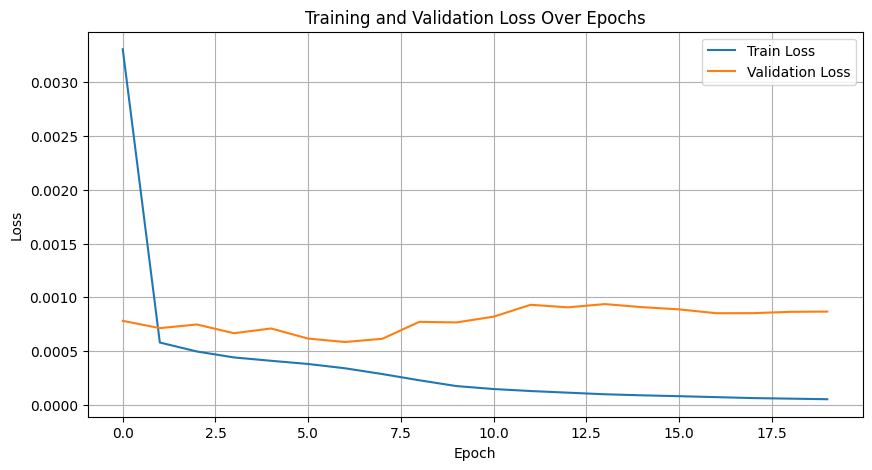

In [24]:
# Train and validate the model
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device, flag=True)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_lstm_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

In [26]:
model_path = "soc_lstm_model.pth"
    
def load_lstm_model(model_path, input_size, hidden_size, num_layers):
    model = SoCLSTM(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers).to(device).type(torch.float32)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_lstm_model(model_path, input_size=len(FEATURE_COLS), hidden_size=128, num_layers=4)

In [27]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [28]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.000355
Test MAE: 0.011802
Test StdDev: 0.018828


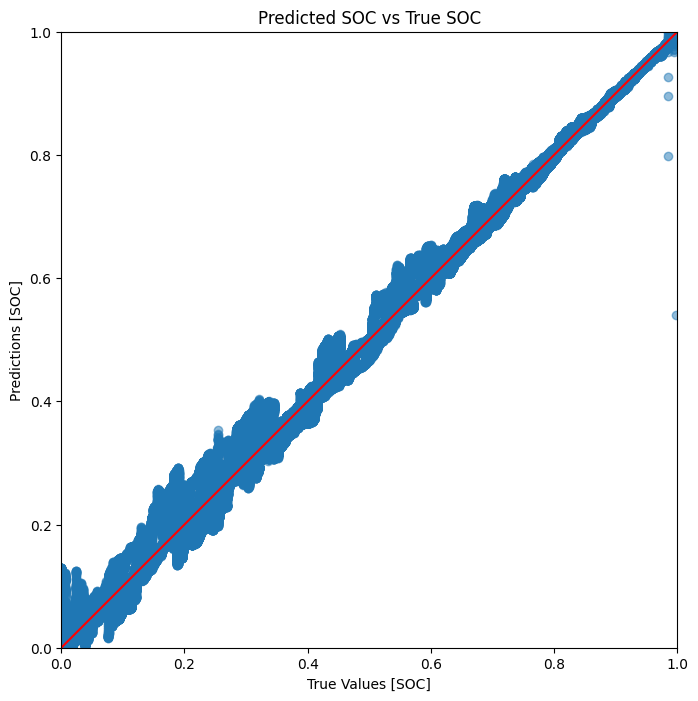

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

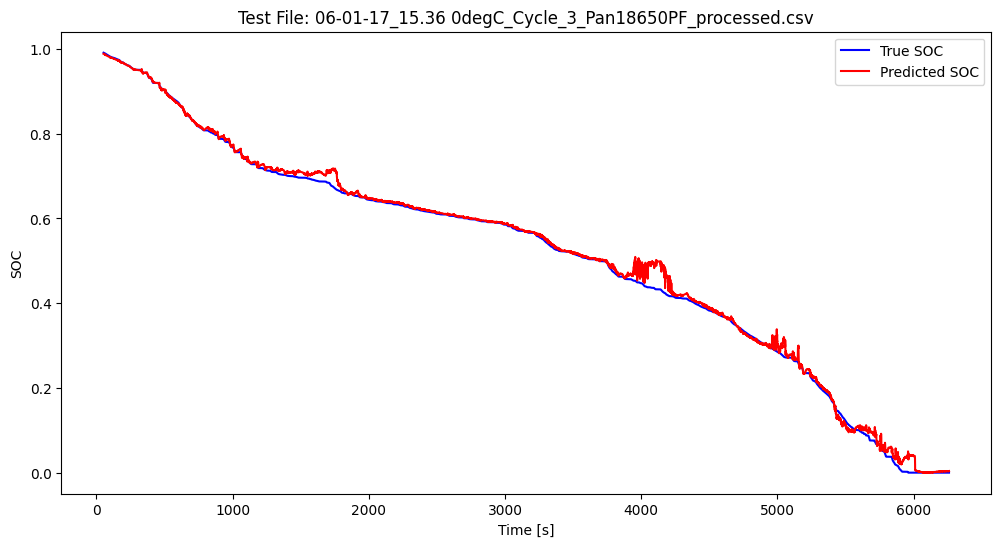

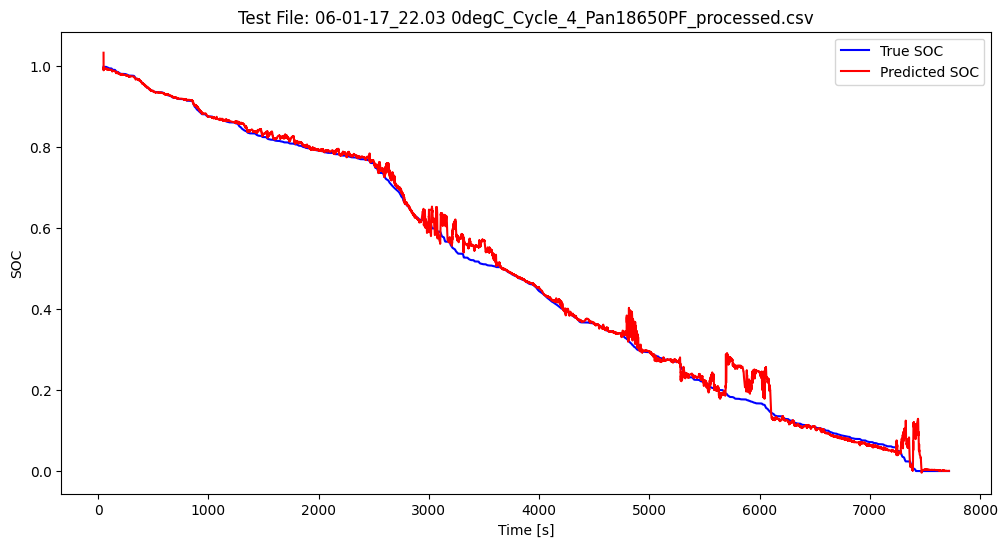

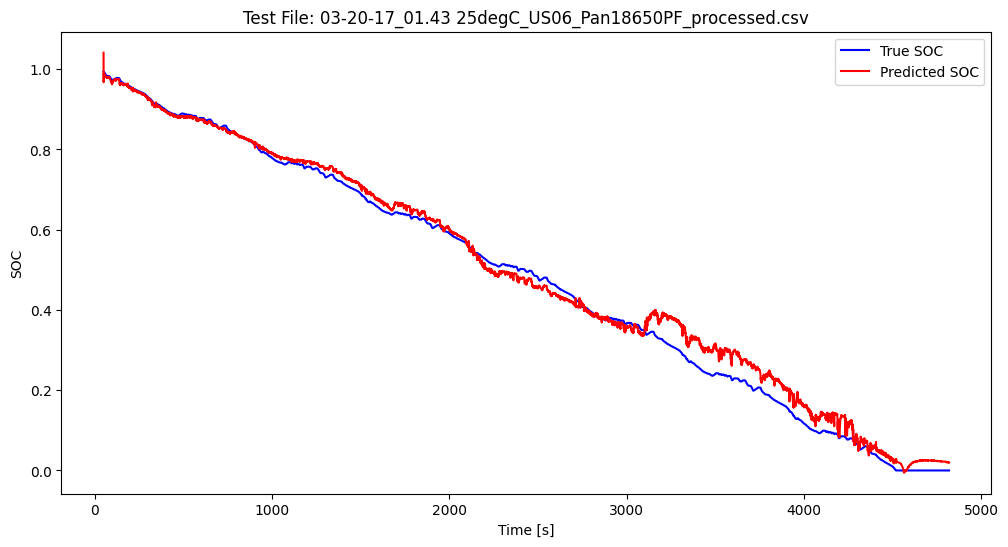

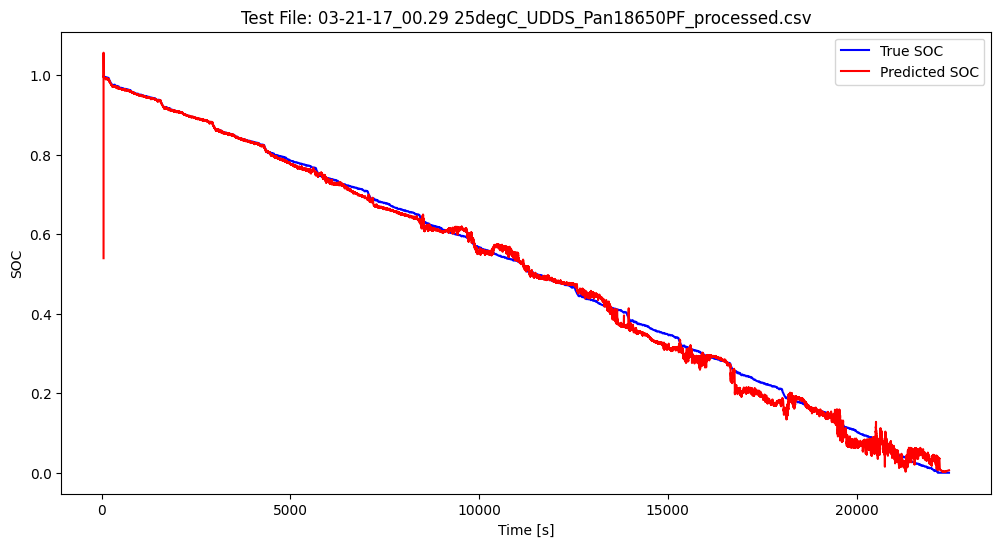

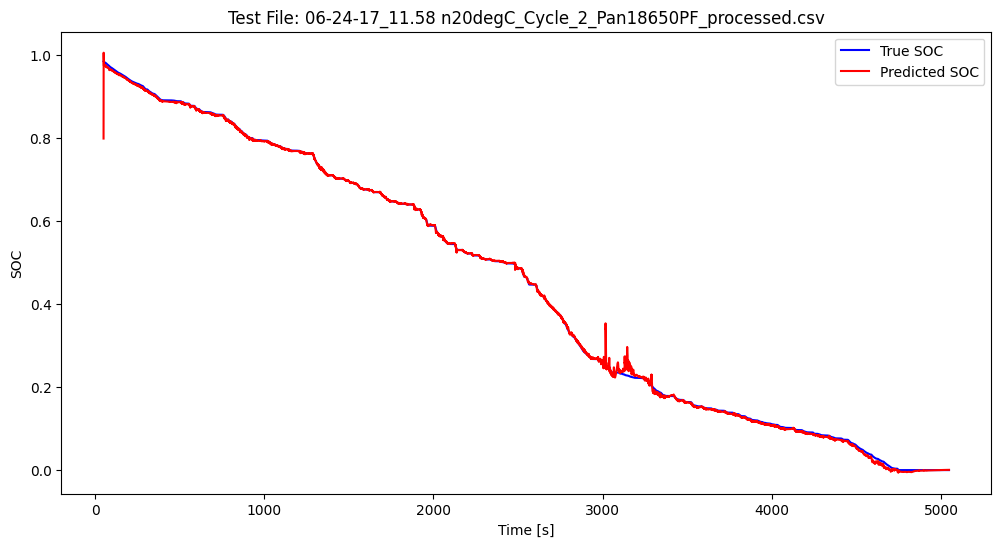

In [30]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)